In [1]:
#https://github.com/ferchault/APDFT/issues/133
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [43]:
def read_file(bnpairs, mode):
    return pd.read_csv('data/ga-search-verbose/%d-%s.log' % (bnpairs, mode), sep=' ', names='gen value pattern'.split()).head(20000)

In [44]:
df = read_file(2, 'MAX')

[0.24947092 0.24947092 0.32670694 0.32670694 0.32670694 0.32670694
 0.32714749 0.32714749 0.32714749 0.37237599]


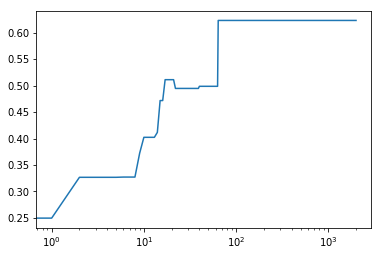

In [45]:
progress = df.groupby('gen').max()['value'].reset_index()
plt.plot(progress.gen,progress.value)
print (progress.value.values[:10])
plt.xscale('log')

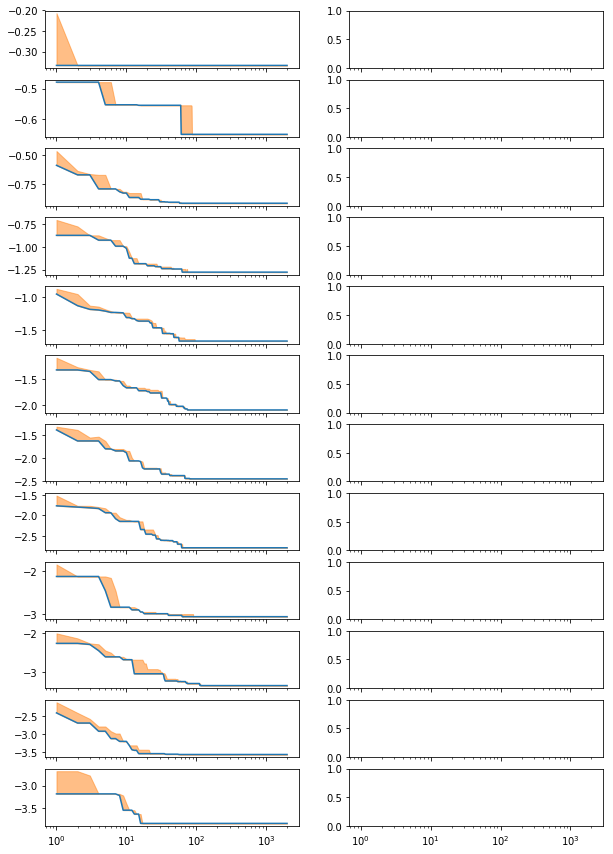

In [57]:
def build_figure(mode):
    if mode not in 'MIN MAX'.split():
        raise ValueError(mode)
    f, axs = plt.subplots(12, 2, figsize=(10, 15), sharex=True)
    for idx in range(12):
        df = read_file(idx+1, mode)
        if mode == 'MAX':
            progress = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            switchfunc = pd.Series.cummax
            bottom = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
        else:
            progress = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
            switchfunc = pd.Series.cummin
            bottom = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            
        axs[idx, 0].plot(progress.gen, switchfunc(progress.value))
        axs[idx, 0].fill_between(bottom.gen, bottom.value, switchfunc(progress.value), color='C1', zorder=-10, alpha=0.5)
        axs[idx, 0].set_xscale('log')
build_figure('MAX')